In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from SubsampledDataset import SubsampledDataset
import torchvision.transforms as transforms
from tqdm import tqdm

import torch
from unet import UNet

In [3]:
# load dataset
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

# Get the val set
val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

val_dataset = SubsampledDataset(val_data, grouper)

BATCH_SIZE = 8
val_loader = get_train_loader("standard", val_dataset, batch_size=BATCH_SIZE)

In [5]:
# Get the val set
id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_dataset = SubsampledDataset(id_val_data, grouper)

BATCH_SIZE = 8
id_val_loader = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

In [61]:
len(id_val_loader)

602

In [7]:
import torch
from unet import UNet
import numpy as np


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
# Unet has skip connections removed
model = UNet(in_channels=3,
             out_channels=3,
             n_blocks=5,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
model = model.to(device)

params_to_optimize = [
    {'params': model.parameters()}
]

loss_fn = torch.nn.L1Loss()

lr= 0.001
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

train_losses = []
val_losses = []

Selected device: cuda


In [6]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()

    train_loss = []
    for image_batch, _, _ in tqdm(dataloader): # ignore labels and metadata
        image_batch = image_batch.to(device)

        model.zero_grad()

        out = model(image_batch)
        
        loss = loss_fn(out, image_batch)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [15]:
### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    
    with torch.no_grad():
      
        conc_out = []
        conc_label = []
        for image_batch, _, _ in dataloader:  # ignore labels and metadata
            image_batch = image_batch.to(device)

            out = model(image_batch)
            
            conc_out.append(out.cpu())
            conc_label.append(image_batch.cpu())
            
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [36]:
num_epochs = 2
for epoch in range(num_epochs):
  print('Epoch %d'%(epoch))
  train_loss = train_epoch(model, device, val_loader, loss_fn, optim)
  train_losses.append(train_loss)

  print('train loss: %10.8f' % train_loss)

torch.save(model.state_dict(), 'models/unet_5_blocks.pt')

100%|██████████| 997/997 [03:52<00:00,  4.28it/s]


Epoch 0
train loss: 0.07203165


100%|██████████| 997/997 [03:53<00:00,  4.26it/s]

Epoch 1
train loss: 0.07239003


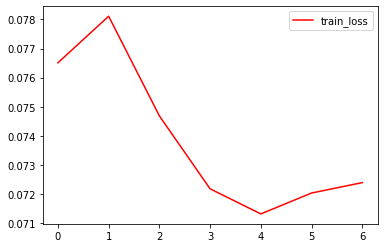

In [37]:
plt.figure()
plt.plot(train_losses, label='train_loss', color='red')
plt.legend()
plt.show()

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
x, _, _ = next(iter(id_val_loader))

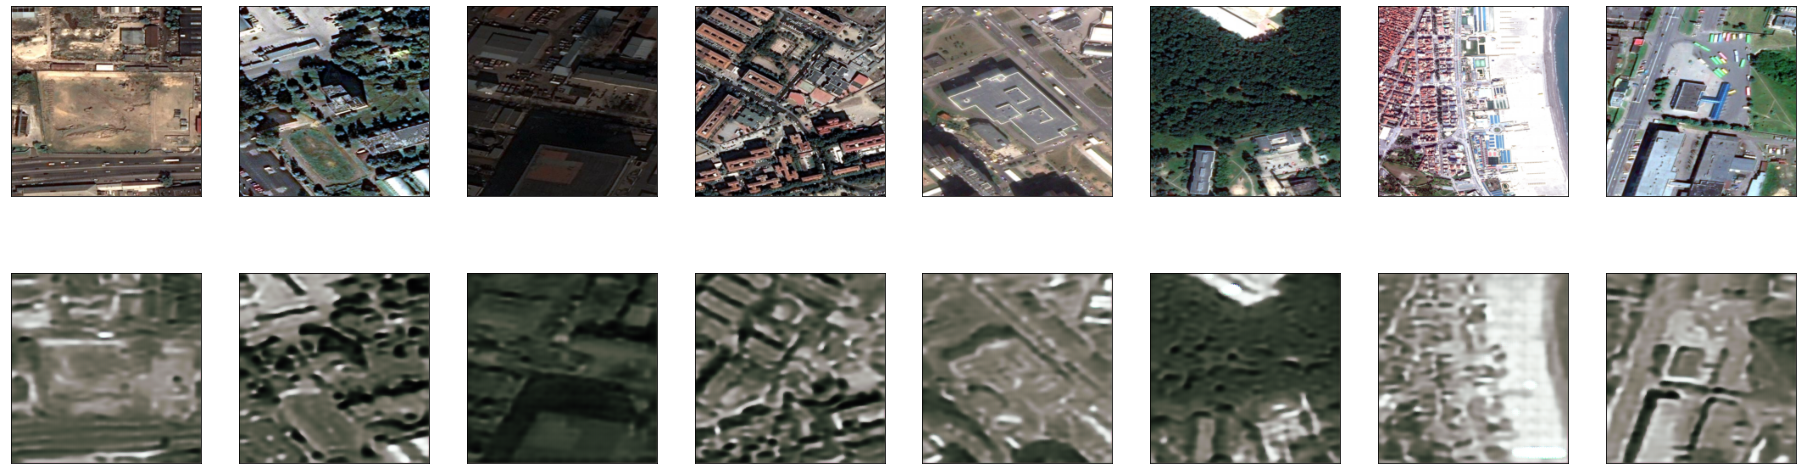

In [30]:
plt.figure(figsize=(32,9))
n = BATCH_SIZE
with torch.no_grad():
  x_pred = model(x.to(device)).cpu()
for i in range(n):
  ax = plt.subplot(2,n,i+1)
  plt.imshow(x[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False) 

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_pred[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  

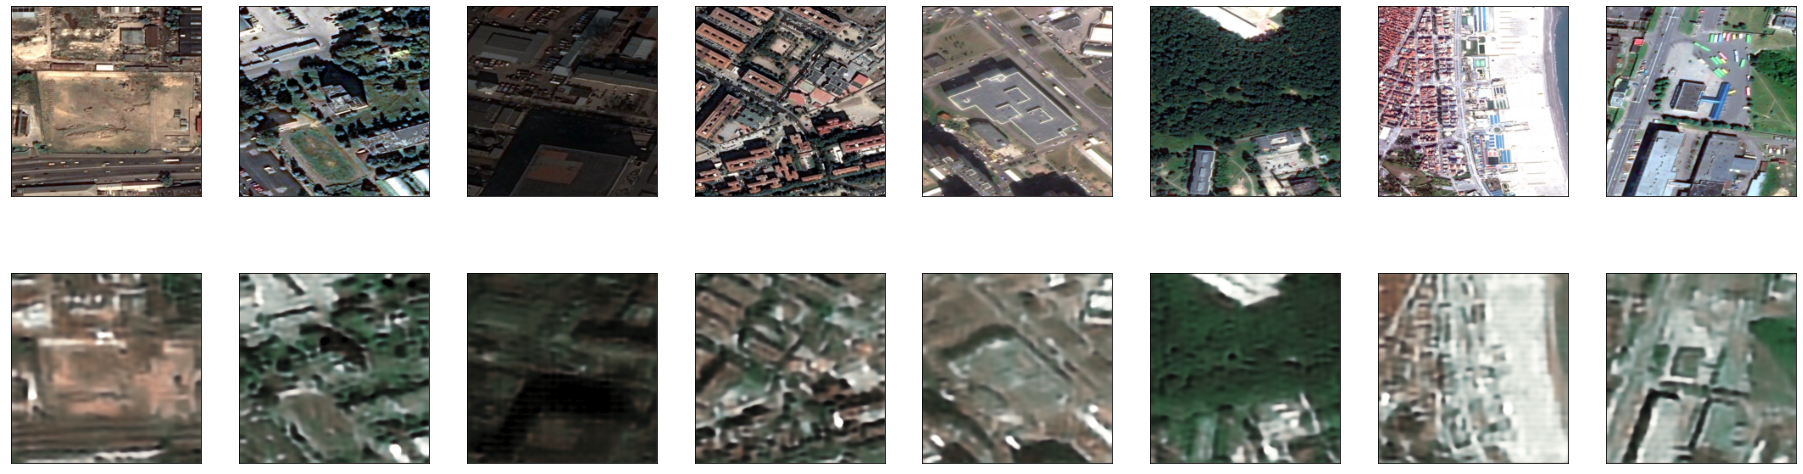

In [32]:
plt.figure(figsize=(32,9))
n = BATCH_SIZE
with torch.no_grad():
  x_pred = model(x.to(device)).cpu()
for i in range(n):
  ax = plt.subplot(2,n,i+1)
  plt.imshow(x[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False) 

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_pred[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  

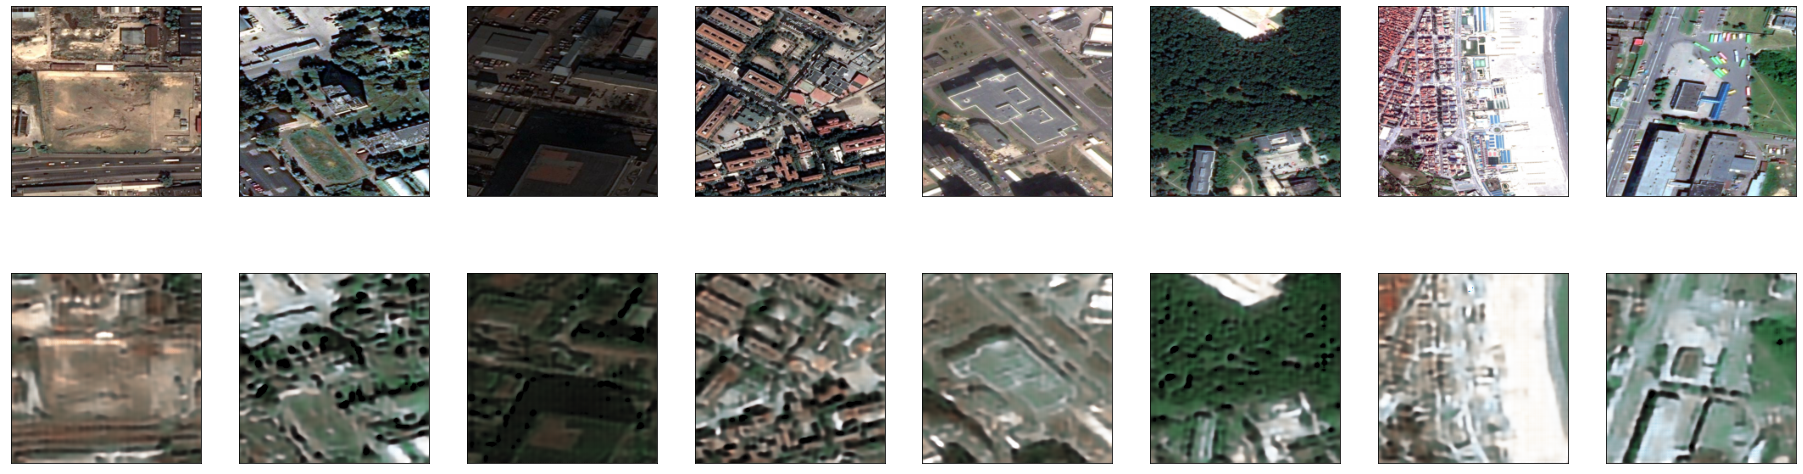

In [34]:
plt.figure(figsize=(32,9))
n = BATCH_SIZE
with torch.no_grad():
  x_pred = model(x.to(device)).cpu()
for i in range(n):
  ax = plt.subplot(2,n,i+1)
  plt.imshow(x[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False) 

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_pred[i].cpu().permute((1, 2, 0)))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  